# Basal topography inversion example: Lugge glacier flowline model

This notebook inverts for basal topography along a flowline using data from Lugge Glacier, assuming the observed surface elevation reflects a steady-state glacier governed by the Shallow Ice Approximation. We do this using the approach of [van Pelt at al. (2013)](https://tc.copernicus.org/articles/7/987/2013/). The next notebook will attempt to do this without the steady-state assumption. 

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from firedrake import *
import os

## Set paths to relevant datasets

In [2]:
# Paths
base_path = '/eejit/home/bezu0001/data/'
centerline_path = base_path + 'centerlines/RGI2000-v7.0-L-15_south_asia_east/RGI2000-v7.0-L-15_south_asia_east.shp'
outline_path = base_path + 'outlines/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp'
velocity_path = base_path + 'velocity/lugge/MedianVelocity_2006.tif'
thickness_path = base_path + 'bed/Thickness-Farinotti/RGI60-15-02373_latlon.tif'
dem_path = base_path + 'elevation/DEM-SRTMv3/SRTMv3_RGI60-15-02373.tif'
smb_path = base_path + 'smb/prf_glacier_ctl.csv'

## Mesh the interval and load data
We can do this by importing [flowline_mesh.py](https://github.com/chrismiele/glimmer/blob/main/meshing/flowline_mesh.ipynb), which contains the necessary functions. 

In [3]:
os.chdir('/eejit/home/bezu0001/icepack/notebooks/GLIMMER/1D_modelling')
from flowline_mesh import interpolate_to_centerline, interval_mesh

mesh = interval_mesh(rgiid = '15-09534', centerline_path = centerline_path, outline_path = outline_path, n_cells = 100, extra_length = 0)

thickness = interpolate_to_centerline(mesh = mesh, data_path = thickness_path, ice_free_value = 0)
dem = interpolate_to_centerline(mesh = mesh, data_path = dem_path, ice_free_value = 0)
bed_val = dem.last_nonzero_value - thickness.last_nonzero_value #obtain the bed value at the last on-glacier location
dem = interpolate_to_centerline(mesh = mesh, data_path = dem_path, ice_free_value = bed_val) #and use it to refine the final on-glacier dem value

smb = interpolate_to_centerline(mesh = mesh, data_path = smb_path, key_value = ' altitude', key_dataset = dem.data, data_value = 'ave_mb')

velocity = interpolate_to_centerline(mesh = mesh, data_path = velocity_path, ice_free_value = 0)

Reprojecting /eejit/home/bezu0001/data/velocity/lugge/MedianVelocity_2006.tif from EPSG:32646 to EPSG:4326


## Plot some of the relevant datasets

Just as a basic sanity check.

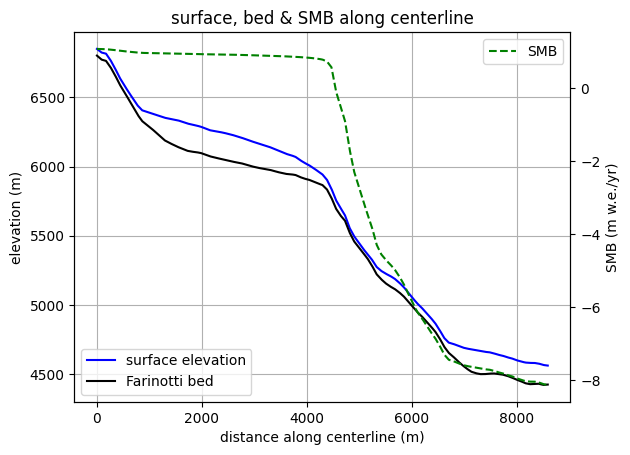

In [4]:
import matplotlib.pyplot as plt
X = np.array([(x,) for x in np.linspace(0, mesh.mesh_length, int(mesh.mesh_length))])

# Sample elevation, thickness, and SMB along the mesh
elevation_profile = np.array(dem.data.at(X, tolerance = 1e-10))
thickness_profile = np.array(thickness.data.at(X, tolerance = 1e-10))
bed_profile = elevation_profile - thickness_profile
smb_profile = np.array(smb.data.at(X, tolerance = 1e-10))

# Plot
fig, ax1 = plt.subplots()
ax1.plot(elevation_profile, color = 'blue', label = 'surface elevation')
ax1.plot(bed_profile, color = 'k', label = 'Farinotti bed')
ax1.set_xlabel('distance along centerline (m)')
ax1.set_ylabel('elevation (m)')
ax1.grid(True)
ax1.legend(loc='lower left')

# Add twin axis for SMB
ax2 = ax1.twinx()
ax2.plot(X.flatten(), smb_profile, color = 'green', linestyle = 'dashed', label = 'SMB')
ax2.set_ylabel('SMB (m w.e./yr)')
ax2.legend(loc='upper right')

plt.title('surface, bed & SMB along centerline')
plt.show()

# Perform the basal inversion

This inversion assumes the glacier is in steady state—meaning the surface elevation should remain unchanged over time if the basal topography is correct. We begin with the observed surface profile and forward model the glacier for ten years. The resulting deviation in surface elevation is used to adjust the bed. This process is repeated until the surface remains stable over the ten-year period, at which point the inferred bed is taken as the true basal topography.

Because surface mass balance is so negative, it's difficult to obtain a steady state. To remedy this while still sort of using the available data, we shift SMB values up uniformly by several metres water equivalent per year. 

## Imports

In [5]:
import icepack#, icepack2
from icepack.constants import ice_density as ρ_I, gravity as g
# from icepack.utilities import itemgetter
#from icepack2 import model
import tqdm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

## Choose physical parameters

In [6]:
T = 273.15 - 0 #ice temperature (K), assumed isothermal
A = Constant(icepack.rate_factor(T))

Q = FunctionSpace(mesh.mesh, 'CG', 1)
x, = SpatialCoordinate(Q)
X = np.arange(0, mesh.glacier_length, 1) #for plotting

s_ref = dem.data.copy(deepcopy = True) #the reference surface for calibrating the inversion
farinotti_bed = Function(Q).project(s_ref - thickness.data) #keep this just for comparison later, but won't use in the inversion
velocity_ref = np.array(velocity.data.at(X, tolerance = 1e-10)) #useful to have some velocity data to inform boundary conditions

H_guess = Function(Q).project(Constant(300)) #assume uniform thickness as an initial guess
bed_guess = Function(Q).project(s_ref - H_guess) #modeled bed begins accordingly
u_guess = Function(Q).project(Constant(velocity_ref[0]))
a = Function(Q).project(smb.data + 3) #assume surface mass balance is considerably less negative than our data...

bed_correction, surface_misfit = Function(Q), Function(Q) #for analysis later

terminus_coordinate = mesh.glacier_length
bed_evolution = [] #for later visualization
surface_evolution = []
velocity_evolution = []
bed_iteration_result = bed_guess.at(X, tolerance = 1e-10)
bed_evolution.append(bed_iteration_result)

## Initialize icepack's SIA solver

In [7]:
opts = {
    'dirichlet_ids' : [1] 
}

flow_model = icepack.models.ShallowIce()
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

## Solve the system iteratively 

In [8]:
num_iterations = 40
K = 0.2 #tuning parameter from van Pelt et al., obtained somewhat arbitrarily
misfits = []

for iteration in tqdm.trange(num_iterations):
    bed_mod = bed_guess.copy(deepcopy = True) #(re-)initialize the modeled bed from most recent guess value
    H_mod = Function(Q).project(s_ref - bed_mod) #modeled thickness...
    u_mod = u_guess.copy(deepcopy = True) #and this

    s_mod = s_ref.copy(deepcopy = True) #but reset this

    Δt = 1/10
    num_years = 10
    num_timesteps = int(num_years/Δt)
        
    for step in range(num_timesteps):
        
        u_mod = flow_solver.diagnostic_solve(velocity = u_mod, thickness = H_mod, surface = s_mod, fluidity = A)
        H_mod = flow_solver.prognostic_solve(Δt, thickness = H_mod, velocity = u_mod, thickness_inflow = H_mod, accumulation = a)
        s_mod.project(bed_mod + H_mod + a*Δt*0)

    surface_misfit.project(s_mod - s_ref)
    bed_correction.project(-K*surface_misfit)
    bed_guess.project(bed_mod + bed_correction) #update the guessed basal elevation

    # keep track of changes to key variables:

    surface_misfit_L2 = np.linalg.norm(np.array(surface_misfit.at(X, tolerance = 1e-10)))
    misfits.append(surface_misfit_L2)
    
    bed_iteration_result = np.array(bed_guess.at(X, tolerance = 1e-10)) #save current guess for later visualization
    surface_iteration_result = np.array(s_mod.at(X, tolerance = 1e-10))
    velocity_iteration_result = np.array(u_mod.at(X, tolerance = 1e-10))
    
    bed_evolution.append(bed_iteration_result)
    surface_evolution.append(surface_iteration_result)
    velocity_evolution.append(velocity_iteration_result)

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [02:14<00:00,  3.35s/it]


## Visualize the results

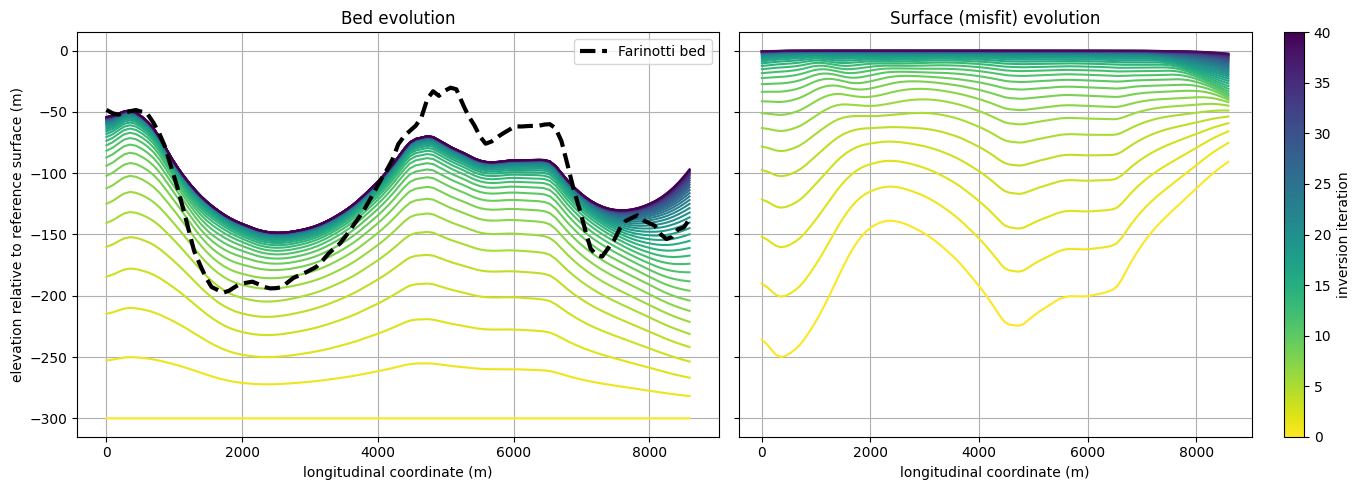

In [9]:
s_ref_array = np.array(s_ref.at(X, tolerance = 1e-10))
farinotti_bed_relative = farinotti_bed.at(X, tolerance = 1e-10) - s_ref_array

# Number of time steps (assumes both lists are same length)
N = len(bed_evolution)

# Shared colormap and normalization
cmap = plt.get_cmap('viridis_r')
norm = Normalize(vmin=0, vmax=N - 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: Bed evolution
for i, entry in enumerate(bed_evolution):
    axes[0].plot(entry - s_ref_array, color=cmap(norm(i)))
axes[0].plot(farinotti_bed_relative, color='k', linestyle='dashed', linewidth = 3, label='Farinotti bed')
axes[0].set_title('Bed evolution')
axes[0].set_xlabel('longitudinal coordinate (m)')
axes[0].set_ylabel('elevation relative to reference surface (m)')
axes[0].legend()
axes[0].grid()

# Right: Surface evolution
for i, entry in enumerate(surface_evolution):
    axes[1].plot(entry - s_ref_array, color=cmap(norm(i)))
axes[1].set_title('Surface (misfit) evolution')
axes[1].set_xlabel('longitudinal coordinate (m)')
axes[1].grid()

# Add single colorbar to the right
sm = ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=axes[1], orientation='vertical', label='inversion iteration')

plt.tight_layout()
plt.show()

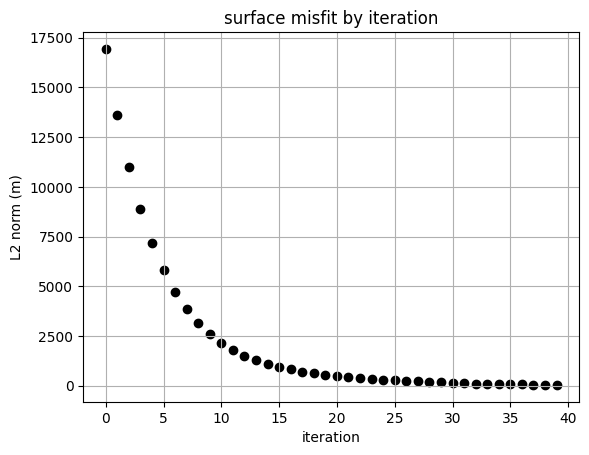

In [10]:
plt.figure()
plt.title('surface misfit by iteration')
plt.scatter(range(len(misfits)), misfits, color = 'k')
plt.ylabel('L2 norm (m)')
plt.xlabel('iteration')
plt.grid(True, which='both')
# plt.ylim(0)
plt.show()

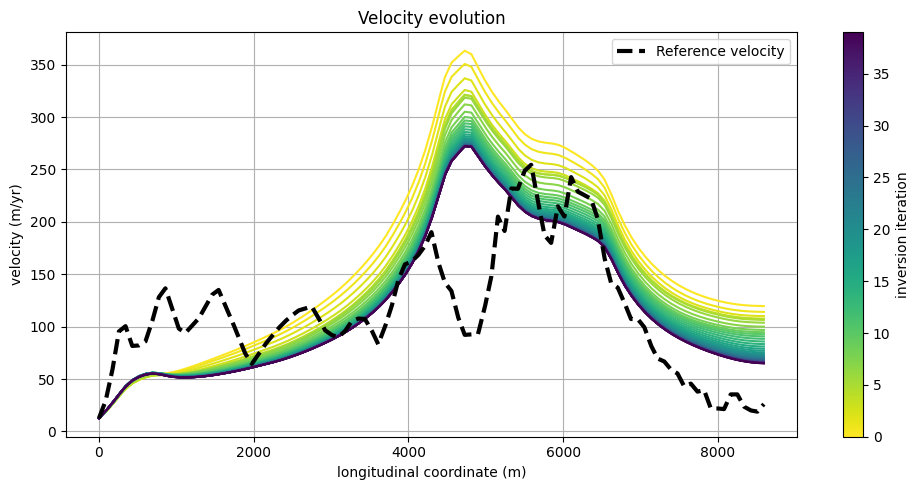

In [11]:
N = len(velocity_evolution)

# Colormap setup
cmap = plt.get_cmap('viridis_r')
norm = Normalize(vmin = 0, vmax = N - 1)

# Plot
fig, ax = plt.subplots(figsize = (10, 5))

for i, v_iter in enumerate(velocity_evolution):
    v_array = np.array(v_iter)
    ax.plot(v_array, color = cmap(norm(i)))

# Plot reference velocity
ax.plot(velocity_ref, color = 'k', linestyle = 'dashed', linewidth = 3, label = 'Reference velocity')

# Labels and formatting
ax.set_title('Velocity evolution')
ax.set_xlabel('longitudinal coordinate (m)')
ax.set_ylabel('velocity (m/yr)')
ax.grid()
ax.legend()

# Add colorbar
sm = ScalarMappable(norm = norm, cmap = cmap)
fig.colorbar(sm, ax = ax, label = 'inversion iteration')

plt.tight_layout()
plt.show()